# Survival Analysis: Understanding Time-to-Event Data
Survival analysis is a statistical method used to analyze the expected duration of time until a specific event occurs. This event could be anything from biological death, disease relapse, mechanical failure, customer churn, or any other outcome of interest.

# Survival Analysis in Cancer Research: Identifying Key Prognostic Factors
The primary objective is to investigate how clinical and demographic factors—such as age, gender, tumor stage, and treatment type—influence the survival duration of lung cancer patients. By applying survival analysis, researchers can:

Determine which patient characteristics significantly impact survival outcomes.
Assess risk factors that may shorten or prolong life expectancy.
Guide personalized treatment plans by identifying high-risk patients who may need more aggressive interventions.
This approach helps oncologists and clinicians make data-driven decisions to improve patient care and prognosis.

##### 1.Group Comparisons:¶-
The Kaplan-Meier estimator visualizes survival probabilities over time for different groups.
- The log-rank test is specifically used to compare survival curves between two or more groupsects.

##### 2.Modeling Covariate Effects:¶-
Cox Proportional Hazards (PH) regression analyzes the impact of categorical/quantitative variables on survival without assuming a baseline hazard distribution
- Parametric survival models (e.g., Weibull, Exponential) assume a specific distribution for survival times and estimate covariate effects.

### Comparative Question
"Among Cox PH, Random Survival Forest (RSF), and Accelerated Failure Time (AFT) models, which one delivers the most accurate survival predictions for lung cancer patients?"
metrics.

#### key Considerations:-
Cox PH: Interpretable for hazard ratios but requires proportional hazards assumptions; may struggle with complex, nonlinear relationships.
- RSF: Handles high-dimensional data and interactions well but acts as a "black box" with less interpretability.
- AFT: Models direct time-scale effects (e.g., "treatment accelerates survival by X months") but assumes a specific distribution (e.g., Weibull, log-normal).

#### Accuracy depends on context:-
If the goal is interpretability and PH assumptions hold, Cox PH may suffice.
- For predictive performance with complex data, RSF often outperforms
- If survival times follow a known distribution, AFT provides intuitive time-ratio metrics.

### Comparing Cox PH, RSF, and AFT  for Survival Prediction 

#### 1. Cox Proportional Hazards (PH) Model 
- Pros: Handles censored data well, provides interpretable hazard ratios, no need to specify baseline hazard.  
- Cons: Assumes proportional hazards, may struggle with complex, non-linear relationships.  

#### 2. Random Survival Forest (RSF) 
- Pros: Handles high-dimensional data, captures non-linear interactions, no strict assumptions.  
- Cons: Less interpretable ("black box"), may overfit with small datasets.  

#### 3. Accelerated Failure Time (AFT) Model 
- Pros: Models survival time directly (e.g., "treatment extends survival by X months"), intuitive interpretation.  
- Cons: Requires specifying a distribution (e.g., Weibull, log-normal), may be less flexible than Cox PH.  

#### Which is Best for Lung Cancer Survival Prediction?  
- If interpretability is key → Cox PH (if proportional hazards hold).  
- If predictive accuracy is priority → RSF (especially with complex interactions).  
- If time-scale effects are of interest → AFT (if data fits a parametric distribution).  

In [214]:
# Required installations 
# !pip install pycox
# !pip install scikit-survival
# !pip install -U lifelines

# Importing required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Survival analysis specific imports
from lifelines import KaplanMeierFitter, CoxPHFitter, WeibullAFTFitter
from lifelines.statistics import logrank_test
from lifelines.utils import concordance_index
from lifelines.calibration import survival_probability_calibration

from pycox.models import CoxPH
import torchtuples as tt

from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored, brier_score

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve

### Dataset Overview

In [216]:
df = pd.read_csv('lung_cancer.xls')
df.head()

,ID,TIME,Y,age,sex,ecog,karnoPH,karnoPAT
0,1,0,0,74,M,1,90,100
1,1,306,1,74,M,1,90,100
2,2,0,0,68,M,0,90,90
3,2,455,1,68,M,0,90,90
4,3,0,0,56,M,0,90,90


In [217]:
df.shape

(456, 8)

In [218]:
# checking missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456 entries, 0 to 455
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        456 non-null    int64 
 1   TIME      456 non-null    int64 
 2   Y         456 non-null    int64 
 3   age       456 non-null    int64 
 4   sex       456 non-null    object
 5   ecog      456 non-null    int64 
 6   karnoPH   456 non-null    int64 
 7   karnoPAT  456 non-null    int64 
dtypes: int64(7), object(1)
memory usage: 28.6+ KB


In [219]:
## checking null values
df.isnull().sum()

ID          0
TIME        0
Y           0
age         0
sex         0
ecog        0
karnoPH     0
karnoPAT    0
dtype: int64

In [220]:
# Looking at the rows with null values
df[df.isnull().any(axis=1)]

,ID,TIME,Y,age,sex,ecog,karnoPH,karnoPAT


In [221]:
# In here, there are a total of 456 data points. Out of these there 8 attributes which have not any missing values in the dataset which are as
df = df.rename(columns={'Y':'status','TIME':'time','karnoPH': 'ph_karno', 'ecog': 'ph_ecog', 'karnoPAT': 'pat_karno'})
df.head()

,ID,time,status,age,sex,ph_ecog,ph_karno,pat_karno
0,1,0,0,74,M,1,90,100
1,1,306,1,74,M,1,90,100
2,2,0,0,68,M,0,90,90
3,2,455,1,68,M,0,90,90
4,3,0,0,56,M,0,90,90


In [222]:
# convert cate value into numeric
df['sex'] = df['sex'].map({'M': 1, 'F': 0})
df

,ID,time,status,age,sex,ph_ecog,ph_karno,pat_karno
0,1,0,0,74,1,1,90,100
1,1,306,1,74,1,1,90,100
2,2,0,0,68,1,0,90,90
3,2,455,1,68,1,0,90,90
4,3,0,0,56,1,0,90,90
...,...,...,...,...,...,...,...,...
451,226,105,0,75,0,2,60,70
452,227,0,0,66,1,1,90,100
453,227,174,0,66,1,1,90,100
454,228,0,0,58,0,1,80,90


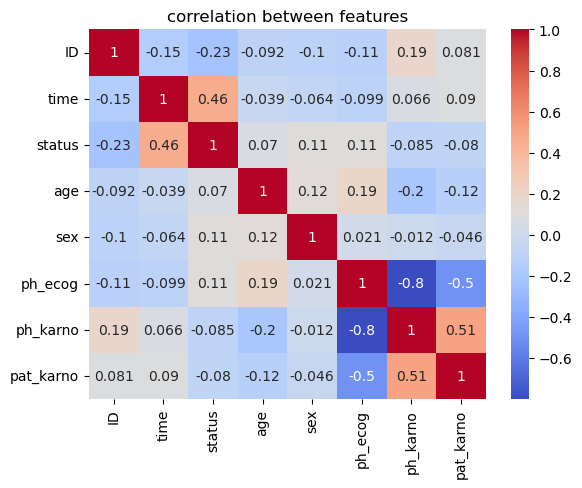

In [223]:
# correlations
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.title("correlation between features")
plt.show()

### Creating Seperate column for "Event of Interest - Death" from the status column

Person is dead when status = 0

Person is alive when status = 1

In [225]:
df.loc[df['status'] == 0, 'dead'] = 0
df.loc[df['status'] == 1, 'dead'] = 1
df.head()

,ID,time,status,age,sex,ph_ecog,ph_karno,pat_karno,dead
0,1,0,0,74,1,1,90,100,0.0
1,1,306,1,74,1,1,90,100,1.0
2,2,0,0,68,1,0,90,90,0.0
3,2,455,1,68,1,0,90,90,1.0
4,3,0,0,56,1,0,90,90,0.0


In [226]:
# finding the number of days a person was alive before they died.

durations = df['time']
event_obs = df['dead']

kmf = KaplanMeierFitter()
kmf.fit(durations, event_obs)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 456 total observations, 291 right-censored observations>

### Event Table Overview from KM Estimator

1. event_at: It stores the value of the timeline for the dataset concerned. i.e., when was the patient observed in the observation. In this case, it is in days. It stores the number of survival days for each subject.

2. observed: These are the number of people that died during the time frame of the experiment. 

3. entrance: It contains the number of new people encountered in a given timeline. There might be cases, where new groups of patients are diagnosed with the disease. 

4. censored: Since we are mainly concerned in finding the survival probability of a patient. At the end of the experiment, if the person is still alive, then they will be added to the censored category.

5. removed: It stores the value of patients who are no longer a part of our experiment. A patient will fall in this category if they either die or are censored.

             removed = observed + censored

 6. at_risk: It stored the value of the number of current patients who are under the observation. At the beginning, it will be nothing but the total number of patients we are concerned during the experiment. But later on, the value will increase with the addition of any newly diagnosed patient during that particular timeframe.

             at_risk = current patients at_risk + entrance - removed


In [228]:
# looking at the event table

event_tab = kmf.event_table

print("Event Table:")

event_tab.head(5)

Event Table:


,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,228,0,228,456,456
5.0,1,1,0,0,228
11.0,3,3,0,0,227
12.0,1,1,0,0,224
13.0,2,2,0,0,223


In [229]:
# survival probability at time t=0:

# theoretical checking of random t values (t = 0, t = 11, t = 13)

# for t = 0 i.e., first row in event table
first_row = event_tab.iloc[0,:]
survival_at_0 = (first_row.at_risk - first_row.observed) / first_row.at_risk
print("Survival at time t = 0 :", survival_at_0)

# for t = 11 i.e., third row in even table
third_row = event_tab.iloc[2,:]
survival_at_11 = (third_row.at_risk - third_row.observed) / third_row.at_risk
print("Survival at time t = 11:", round(survival_at_11, 3))

# for t = 13 i.e., fifth row in even table
fifth_row = event_tab.iloc[4,:]
survival_at_13 = (fifth_row.at_risk - fifth_row.observed) / fifth_row.at_risk
print("Survival at time t = 13:", round(survival_at_13, 3))

Survival at time t = 0 : 1.0
Survival at time t = 11: 0.987
Survival at time t = 13: 0.991


In [230]:
# Using kmf's predict function to call out the survival probabilities
kmf.predict(11)

0.9824561403508766

In [231]:
# looking at all the KM estimates
survival_ls = kmf.survival_function_
survival_ls.head()

,KM_estimate
timeline,
0.0,1.000000
5.0,0.995614
11.0,0.982456
12.0,0.978070
13.0,0.969298


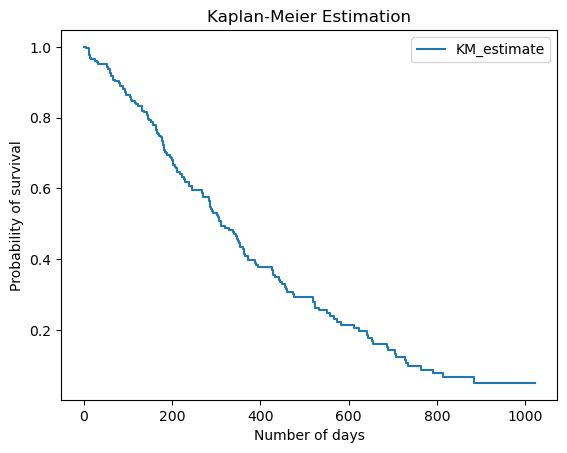

In [232]:
# Plotting the event observed against the timeframe of reference
kmf.plot(ci_show=False)
plt.title("Kaplan-Meier Estimation")
plt.xlabel("Number of days")
plt.ylabel("Probability of survival");

### Median Survival Period (in days)

In [234]:
# looking at the median number of survival days i.e., the number of days, on an average, 50% of the patients survived.
print("The median survival time:", kmf.median_survival_time_, "days.")

The median survival time: 310.0 days.


From the value of the median survival days, we can say, that after the diagnosis of lung cancer, a patient, on an average is alive for 310 days

In [236]:
# Survival Probability with confidence intervals
kmf.confidence_interval_survival_function_

,KM_estimate_lower_0.95,KM_estimate_upper_0.95
0.0,1.000000,1.000000
5.0,0.969277,0.999381
11.0,0.953935,0.993379
12.0,0.948120,0.990813
13.0,0.936682,0.985244
...,...,...
840.0,0.030728,0.123060
883.0,0.017866,0.108662
965.0,0.017866,0.108662
1010.0,0.017866,0.108662


### Plotting the graph for survival probability with confidence interval


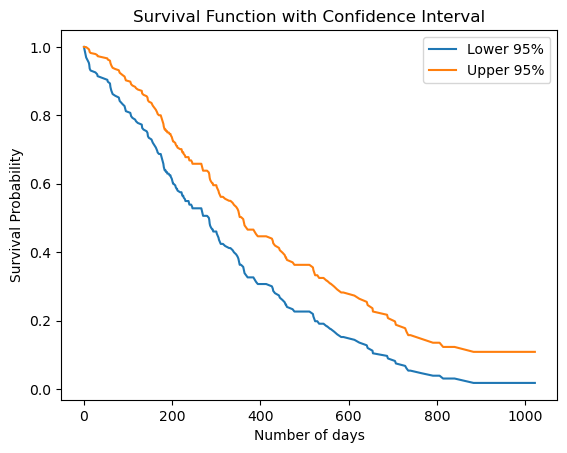

In [238]:
confidence_surv_func = kmf.confidence_interval_survival_function_

plt.plot(confidence_surv_func["KM_estimate_lower_0.95"], label = "Lower 95%")
plt.plot(confidence_surv_func["KM_estimate_upper_0.95"], label = "Upper 95%")
plt.title("Survival Function with Confidence Interval")
plt.xlabel("Number of days")
plt.ylabel("Survival Probability")
plt.legend();

In [239]:
event_tab

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,228,0,228,456,456
5.0,1,1,0,0,228
11.0,3,3,0,0,227
12.0,1,1,0,0,224
13.0,2,2,0,0,223
...,...,...,...,...,...
840.0,1,0,1,0,5
883.0,1,1,0,0,4
965.0,1,0,1,0,3


In [240]:
# finally the cumulative density:
kmf.cumulative_density_

,KM_estimate
timeline,
0.0,0.000000
5.0,0.004386
11.0,0.017544
12.0,0.021930
13.0,0.030702
...,...
840.0,0.932873
883.0,0.949654
965.0,0.949654


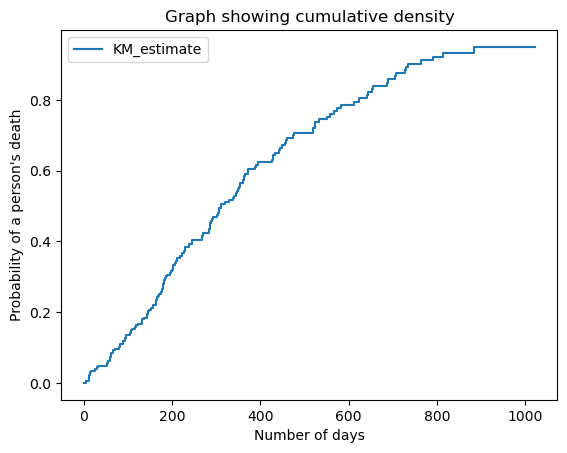

In [241]:
# plotting the graph for the cumulative density:
kmf.plot_cumulative_density(ci_show=False)
plt.title("Graph showing cumulative density")
plt.xlabel("Number of days")
plt.ylabel("Probability of a person's death");

As the number of survival days increase, the probability of a person dying decreases.

In [243]:
confidence_cumulative_density = kmf.confidence_interval_cumulative_density_
confidence_cumulative_density

,KM_estimate_lower_0.95,KM_estimate_upper_0.95
0.0,0.000000,0.000000
5.0,0.000619,0.030723
11.0,0.006621,0.046065
12.0,0.009187,0.051880
13.0,0.014756,0.063318
...,...,...
840.0,0.876940,0.969272
883.0,0.891338,0.982134
965.0,0.891338,0.982134
1010.0,0.891338,0.982134


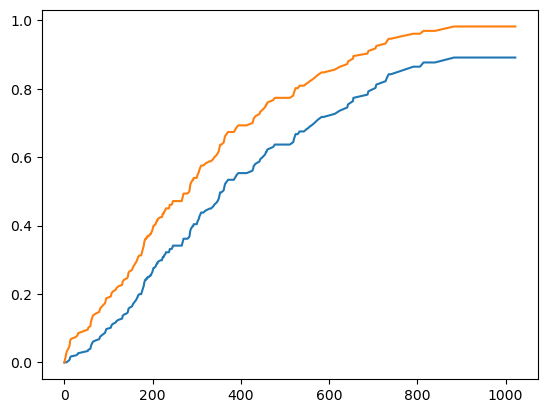

In [244]:
plt.plot(confidence_cumulative_density["KM_estimate_lower_0.95"], label = "Lower 95%")
plt.plot(confidence_cumulative_density["KM_estimate_upper_0.95"], label = "Upper 95%");


### The median time to an event:

The median survival time can help us get the the amount of time remaining to an event

In [246]:
# Calculating the conditional median time to the event
kmf.conditional_time_to_event_

,KM_estimate - Conditional median duration remaining to event
timeline,
0.0,310.0
5.0,305.0
11.0,309.0
12.0,308.0
13.0,316.0
...,...
840.0,inf
883.0,inf
965.0,inf


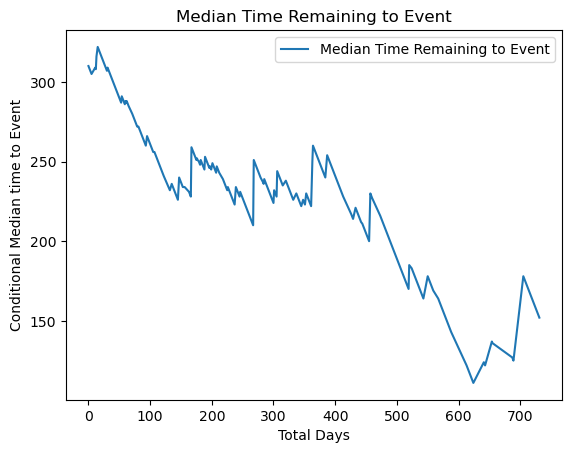

In [247]:
# Graph for the median time to an event
# Conditional median time left for event:

median_time_to_event = kmf.conditional_time_to_event_

plt.plot(median_time_to_event, label = "Median Time Remaining to Event")
plt.title("Median Time Remaining to Event")
plt.xlabel("Total Days")
plt.ylabel("Conditional Median time to Event")
plt.legend();

### Hazard Function H(t)

The Kaplan-Meier survival function provides the probability that the event of interest (such as death) has not occurred by a certain time. While survival functions are useful for summarizing and visualizing survival data, we can also gain insight into survival patterns using the Nelson-Aalen estimator of the hazard function h(t). This hazard function represents the probability that an individual who is still under observation at time t experiences the event (e.g., death) at that exact moment.

Unlike the survival function, the hazard function cannot be derived directly from the Kaplan-Meier estimator. Instead, we use a dedicated nonparametric approach to estimate the cumulative hazard function.


In [249]:
# import the Nelson Aalen hazard model
from lifelines import NelsonAalenFitter

In [250]:
# object for NelsonAalenFitter
naf = NelsonAalenFitter()

In [251]:
# Fitting the data
naf.fit(df['time'], event_observed=df['dead'])

<lifelines.NelsonAalenFitter:"NA_estimate", fitted with 456 total observations, 291 right-censored observations>

In [252]:
# finding the cumulative hazard:
naf.cumulative_hazard_

,NA_estimate
timeline,
0.0,0.000000
5.0,0.004386
11.0,0.017660
12.0,0.022125
13.0,0.031114
...,...
840.0,2.641565
883.0,2.891565
965.0,2.891565


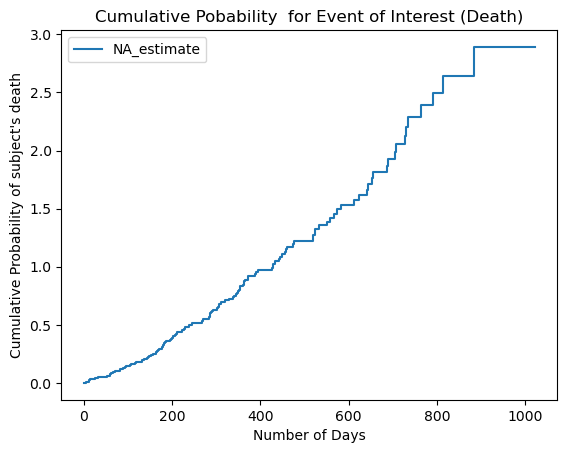

In [253]:
# plotting the cumulative hazard graph
naf.plot_cumulative_hazard(ci_show=False)
plt.title("Cumulative Pobability  for Event of Interest (Death)")

plt.xlabel("Number of Days")
plt.ylabel("Cumulative Probability of subject's death");

## Comparison of the different groups of the attributes using the Kaplan Meier Curve

In [255]:
# creating a separate of the actual dataframe for this phase of analysis
df2 = df.copy()

### 1. Dividing the population into two groups by sex to check if the sex has any affect on the survival.

In [257]:
df['sex'] = df['sex'].map({'M': 1, 'F': 0})

In [258]:
male = df2[df2['sex'] == 1]
female = df2[df2['sex'] == 0]
results = logrank_test(male['time'], female['time'], male['dead'], female['dead'])
print(f"\nLog-rank test p-value: {results.p_value:.4f}")
if results.p_value < 0.05:
    print("Significant difference in survival between genders (p < 0.05)")
else:
    print("No significant difference in survival between genders")


Log-rank test p-value: 0.0013
Significant difference in survival between genders (p < 0.05)


p-value = 0.0013
This is much smaller than the typical significance threshold of 0.05

There's only a 0.13% probability that the observed survival difference occurred by random chance

"Significant difference" conclusion

The survival curves for males and females are statistically different

One gender likely has better/worse survival outcomes than the other

In [260]:
# creating 2 objects for the two groups:
kmf_males = KaplanMeierFitter()
kmf_females = KaplanMeierFitter()

In [261]:
# # dividing the data into groups:
# males = df2.query("sex == 1")
# females = df2.query("sex == 0")
males = df2[df2['sex'] == 1]
females = df2[df2['sex'] == 0]

In [262]:
# fitting the data into the models.
kmf_males.fit(durations= males['time'], event_observed= males['dead'], label= "Males")
kmf_females.fit(durations= females['time'], event_observed= females['dead'], label= "Females")

<lifelines.KaplanMeierFitter:"Females", fitted with 180 total observations, 127 right-censored observations>

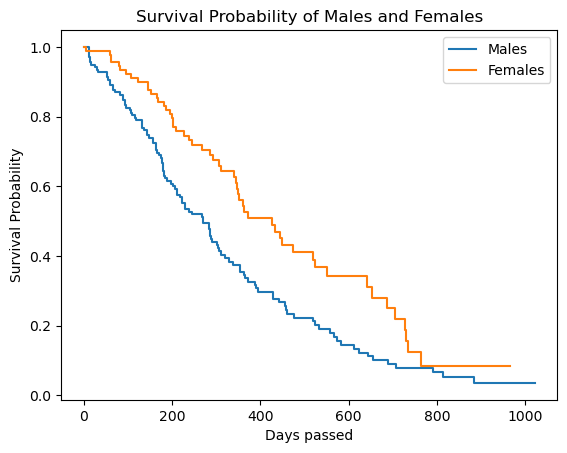

In [263]:
# plotting the graph for the two groups:

kmf_males.plot(ci_show = False)
kmf_females.plot(ci_show = False)

plt.xlabel("Days passed")
plt.ylabel("Survival Probability")
plt.title("Survival Probability of Males and Females");

From the graph it can be inferred that males have a comparatively lower chances of survival compared to females.

### 2. Dividing the population into two groups by ages to check if the age has any affect on the survival.

In [266]:
# dividing the age into different categories : 1 -> greater than 70 and 0 -> lesser than 70
df_age_cats = df2.copy()

df_age_cats.loc[df_age_cats['age'] >= 70, 'age_cat'] = 1
df_age_cats.loc[df_age_cats['age'] < 70, 'age_cat'] = 0

In [267]:
df_age_cats.head(2)

,ID,time,status,age,sex,ph_ecog,ph_karno,pat_karno,dead,age_cat
0,1,0,0,74,1,1,90,100,0.0,1.0
1,1,306,1,74,1,1,90,100,1.0,1.0


In [268]:
# creating kmf objects for the two groups and fitting the categorized data
old   = df2[df2['age'] >= 70].copy()
young = df2[df2['age'] <  70].copy()

old   = old.dropna(subset=['time','dead'])
young = young.dropna(subset=['time','dead'])
kmf_old = KaplanMeierFitter()
kmf_young = KaplanMeierFitter()

kmf_old.fit(durations= old['time'], event_observed= old['dead'], label= "More than 70 years")
kmf_young.fit(durations= young['time'], event_observed= young['dead'], label= "Less than 70 years")

<lifelines.KaplanMeierFitter:"Less than 70 years", fitted with 344 total observations, 225 right-censored observations>

In [269]:
# Log-rank test
results = logrank_test(old['time'], young['time'], old['dead'], young['dead'])
print(f"\nLog-rank test p-value: {results.p_value:.4f}")
if results.p_value < 0.05:
    print("Conclusion: Significant difference in survival between age groups (p < 0.05)")
else:
    print("Conclusion: No significant difference in survival between age groups")


Log-rank test p-value: 0.0442
Conclusion: Significant difference in survival between age groups (p < 0.05)


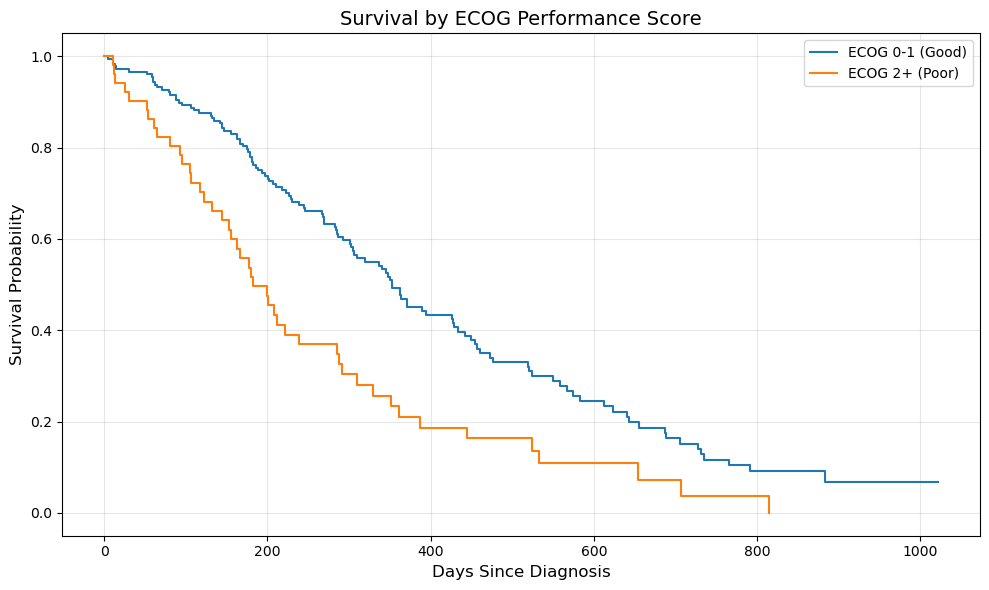

In [270]:
# ECOG score groups
df_clean = df2.copy()
df_clean['ph_ecog_cat'] = df_clean['ph_ecog'].apply(lambda x: '0-1' if x in [0, 1] else '2+')

plt.figure(figsize=(10,6))
kmf_ecog_low = KaplanMeierFitter()
kmf_ecog_high = KaplanMeierFitter()

ecog_low = df_clean[df_clean['ph_ecog_cat'] == '0-1']
ecog_high = df_clean[df_clean['ph_ecog_cat'] == '2+']

kmf_ecog_low.fit(ecog_low['time'], ecog_low['dead'], label='ECOG 0-1 (Good)')
kmf_ecog_high.fit(ecog_high['time'], ecog_high['dead'], label='ECOG 2+ (Poor)')

ax = kmf_ecog_low.plot(ci_show=False)
kmf_ecog_high.plot(ax=ax, ci_show=False)
plt.title('Survival by ECOG Performance Score', fontsize=14)
plt.xlabel('Days Since Diagnosis', fontsize=12)
plt.ylabel('Survival Probability', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

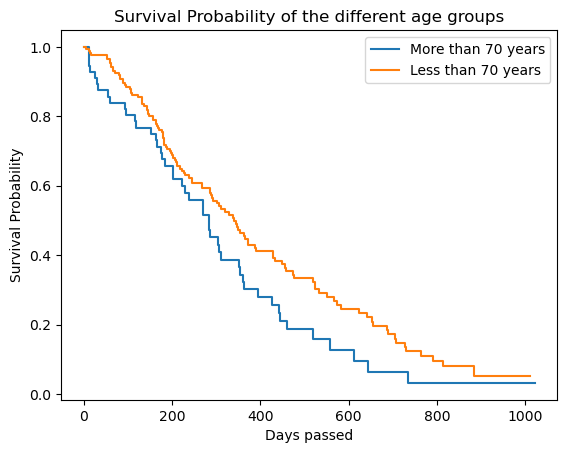

In [271]:
# plotting the graph for the two groups:


kmf_old.plot(ci_show = False)
kmf_young.plot(ci_show = False)

plt.xlabel("Days passed")
plt.ylabel("Survival Probability")
plt.title("Survival Probability of the different age groups");

From the graph above, it can be inferred that subjects who are older than 70 years have a comparatively lower chances of survival compared to subjects younger than 70 years.

### 3. Dividing the population into two groups the ph.karno scores

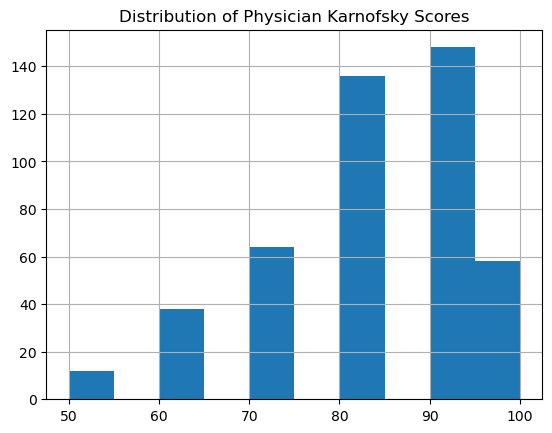

In [274]:
df2['ph_karno'].hist();
plt.title("Distribution of Physician Karnofsky Scores");

### Group Division:

A ph.karno score of >= 80 will consider all patiens who are able to carry on normaly activity without special care. People with less than 80 are considered actually ill with people having >  40 scores as really sick.

Considering this, the two groups are made as:
1. People with <= 80 pat.karno score
2. People with > 80 pat.karno score

In [276]:
# dividing the age into 2 categories :
# 1 -> people who have a ph.karno >= 80 -- healthy
# 0 -> people who have a ph.karno < 80 -- sick
df_pat_karno = df2.copy()

df_pat_karno.loc[df_pat_karno['pat_karno'] >= 80, 'pat_karno_cat'] = 1
df_pat_karno.loc[df_pat_karno['pat_karno'] < 80, 'pat_karno_cat'] = 0

In [277]:
# dividing the data into groups:

pat_karno_healthy = df_pat_karno.query("pat_karno_cat == 1")
pat_karno_sick = df_pat_karno.query("pat_karno_cat == 0")

In [278]:
# creating kmf objects for the two groups and fitting the categorized data

kmf_pat_karno_healthy = KaplanMeierFitter()
kmf_pat_karno_sick = KaplanMeierFitter()


kmf_pat_karno_healthy.fit(durations = pat_karno_healthy['time'], event_observed = pat_karno_healthy['dead'], label= "Pat-Karno greater than 80 (Healthy)")
kmf_pat_karno_sick.fit(durations = pat_karno_sick['time'], event_observed = pat_karno_sick['dead'], label= "Pat-Karno less than 80 (Sick)")

<lifelines.KaplanMeierFitter:"Pat-Karno less than 80 (Sick)", fitted with 158 total observations, 94 right-censored observations>

<lifelines.KaplanMeierFitter:"Pat-Karno less than 80 (Sick)", fitted with 158 total observations, 94 right-censored observations>

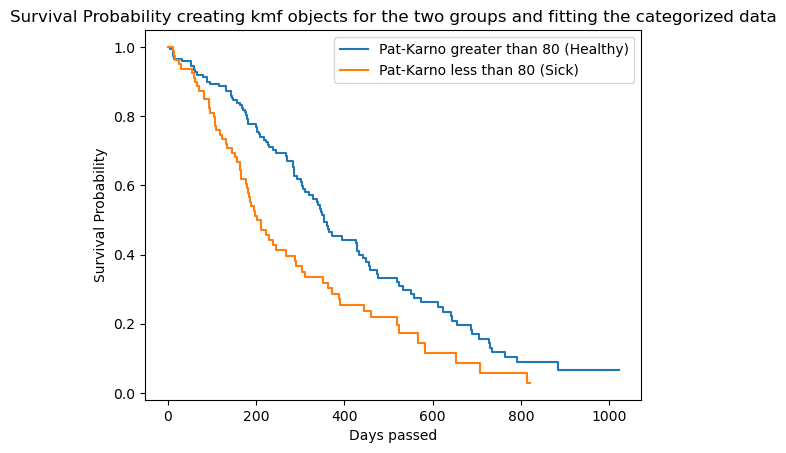

In [279]:
# plotting the graph for the two groups:

kmf_pat_karno_healthy.plot(ci_show = False)
kmf_pat_karno_sick.plot(ci_show = False)

plt.xlabel("Days passed")
plt.ylabel("Survival Probability")
plt.title("Survival Probability creating kmf objects for the two groups and fitting the categorized data")

kmf_pat_karno_healthy = KaplanMeierFitter()
kmf_pat_karno_sick = KaplanMeierFitter()
kmf_pat_karno_healthy.fit(durations = pat_karno_healthy['time'], event_observed = pat_karno_healthy['dead'], label= "Pat-Karno greater than 80 (Healthy)")
kmf_pat_karno_sick.fit(durations = pat_karno_sick['time'], event_observed = pat_karno_sick['dead'], label= "Pat-Karno less than 80 (Sick)")

From the graph above, it can be inferred that subjects with Patient Karnofsky score less than 80 have lower chances or survival.

### 4. Dividing the population into two groups the ph.karno scores


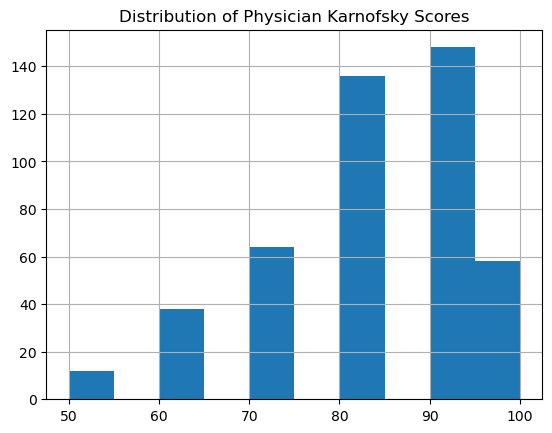

In [282]:
df2['ph_karno'].hist();
plt.title("Distribution of Physician Karnofsky Scores");

A ph.karno score of >= 80 will consider all patiens who are able to carry on normaly activity without special care. People with less than 80 are considered actually ill with people having >  40 scores as really sick.

Considering this, the two groups are made as:
1. People with <= 80 ph.karno score
2. People with > 80 ph.karno score

In [284]:
# dividing the age into 2 categories :
# 1 -> people who have a ph.karno >= 80 -- healthy
# 0 -> people who have a ph.karno < 80 -- sick
df_ph_karno = df2.copy()

df_ph_karno.loc[df_ph_karno['ph_karno'] >= 80, 'ph_karno_cat'] = 1
df_ph_karno.loc[df_ph_karno['ph_karno'] < 80, 'ph_karno_cat'] = 0

In [285]:
# dividing the data into groups:

ph_karno_healthy = df_ph_karno.query("ph_karno_cat == 1")
ph_karno_sick = df_ph_karno.query("ph_karno_cat == 0")

In [286]:
# creating kmf objects for the two groups and fitting the categorized data

kmf_ph_karno_healthy = KaplanMeierFitter()
kmf_ph_karno_sick = KaplanMeierFitter()

kmf_ph_karno_healthy.fit(durations = ph_karno_healthy['time'], event_observed = ph_karno_healthy['dead'], label= "Ph-Karno greater than 80 (Healthy)")
kmf_ph_karno_sick.fit(durations = ph_karno_sick['time'], event_observed = ph_karno_sick['dead'], label= "Ph-Karno less than 80 (Sick)")

<lifelines.KaplanMeierFitter:"Ph-Karno less than 80 (Sick)", fitted with 114 total observations, 64 right-censored observations>

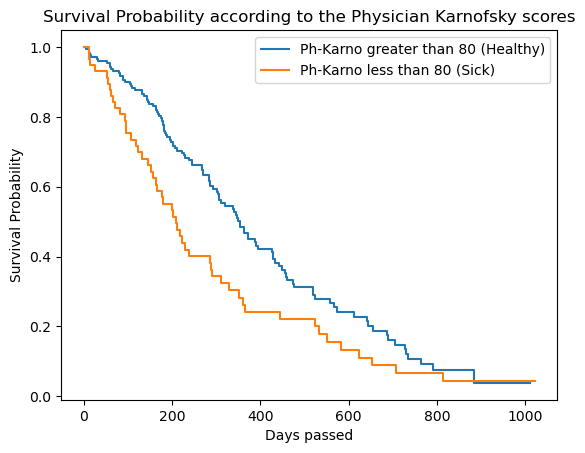

In [287]:
# plotting the graph for the two groups:

kmf_ph_karno_healthy.plot(ci_show = False)
kmf_ph_karno_sick.plot(ci_show = False)

plt.xlabel("Days passed")
plt.ylabel("Survival Probability")
plt.title("Survival Probability according to the Physician Karnofsky scores");

From the graph above, it can be inferred that subjects having Physician Karnofsky score less than 80 have lower chances or survival.

### 5. Dividing the population into two groups by the ph.ecog scores

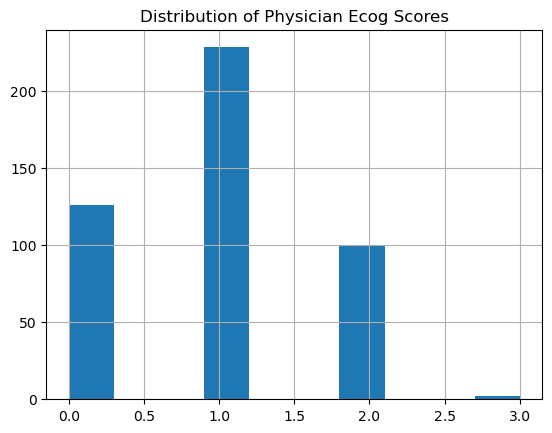

In [290]:
df2['ph_ecog'].hist()
plt.title("Distribution of Physician Ecog Scores");


A ph.karno score of less than equal to 1 will consider all patiens who are able to carry on normaly activity without special care. People with greater than 1 are considered actually ill.

Considering this, the two groups are made as:
1. People with >= 1 ph.karno score
2. People with < 1 ph.karno score

In [292]:
# dividing the age into 2 categories :
# 1 -> people who have a ph.ecog <= 1 -- healthy
# 0 -> people who have a ph.karno > 1 -- sick
df_ph_ecog = df2.copy()

df_ph_ecog.loc[df_ph_ecog['ph_ecog'] <= 1, 'ph_ecog_cat'] = 1
df_ph_ecog.loc[df_ph_ecog['ph_ecog'] > 1, 'ph_ecog_cat'] = 0

In [293]:
# dividing the data into groups:

ph_ecog_health = df_ph_ecog.query("ph_ecog_cat == 1")
ph_ecog_sick = df_ph_ecog.query("ph_ecog_cat == 0")

In [294]:
# creating kmf objects for the two groups and fitting the categorized data

kmf_ph_ecog_healthy = KaplanMeierFitter()
kmf_ph_ecog_sick = KaplanMeierFitter()

kmf_ph_ecog_healthy.fit(durations = ph_ecog_health['time'], event_observed = ph_ecog_health['dead'], label= "Ph-Ecog lesser than 1 (Healthy)")
kmf_ph_ecog_sick.fit(durations = ph_ecog_sick['time'], event_observed = ph_ecog_sick['dead'], label= "Ph-Ecog greater than 1 (Sick)")

<lifelines.KaplanMeierFitter:"Ph-Ecog greater than 1 (Sick)", fitted with 102 total observations, 57 right-censored observations>

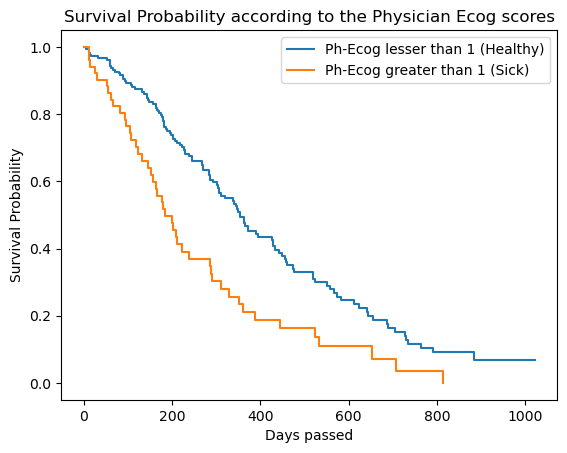

In [295]:
# plotting the graph for the two groups:

kmf_ph_ecog_healthy.plot(ci_show = False)
kmf_ph_ecog_sick.plot(ci_show = False)

plt.xlabel("Days passed")
plt.ylabel("Survival Probability")
plt.title("Survival Probability according to the Physician Ecog scores");

From the above graph here, it can be inferred that the subjects having Physician Ecog scores less than 1 have lower chances of survival.

In [297]:
# looking at the null values:
df2.isnull().sum()

ID           0
time         0
status       0
age          0
sex          0
ph_ecog      0
ph_karno     0
pat_karno    0
dead         0
dtype: int64

In [298]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456 entries, 0 to 455
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         456 non-null    int64  
 1   time       456 non-null    int64  
 2   status     456 non-null    int64  
 3   age        456 non-null    int64  
 4   sex        456 non-null    int64  
 5   ph_ecog    456 non-null    int64  
 6   ph_karno   456 non-null    int64  
 7   pat_karno  456 non-null    int64  
 8   dead       456 non-null    float64
dtypes: float64(1), int64(8)
memory usage: 32.2 KB


In [299]:
# running a base analysis first by removing all the null values without any imputation

# temporary copy of the original dataframe
df_cph = df2.copy()

dropper_subset = list(df_cph.columns)
df_cph.dropna(subset=dropper_subset, inplace=True)
df_cph.drop(['status'], axis=1, inplace=True) # dropping the status column also as the dead column is sufficient

In [300]:
df2.head()

,ID,time,status,age,sex,ph_ecog,ph_karno,pat_karno,dead
0,1,0,0,74,1,1,90,100,0.0
1,1,306,1,74,1,1,90,100,1.0
2,2,0,0,68,1,0,90,90,0.0
3,2,455,1,68,1,0,90,90,1.0
4,3,0,0,56,1,0,90,90,0.0


In [301]:
df_clean = df2.copy()

## Model Comparison

In [303]:
def _prepare_data(df):
    """Common data preparation steps for all models."""
    df = df.copy()
    df['time'] = df['time'].clip(lower=0.1)
    if 'ID' in df.columns:
        df = df.drop(columns=['ID'])
    return train_test_split(df, test_size=0.3, random_state=42)

In [304]:
def _get_evaluation_times(train_df):
    """Get evaluation times based on event times."""
    event_times = train_df.loc[train_df['dead'] == 1, 'time']
    return np.quantile(event_times[event_times > 0], [0.25, 0.5, 0.75])

In [305]:
def _calculate_brier_scores(test_df, surv_prob, times, model_name=""):
    """Calculate and print Brier scores at evaluation times."""
    print("\nBrier Scores:")
    brier_scores = []
    
    for i, t in enumerate(times):
        preds = 1 - surv_prob.iloc[i].values if hasattr(surv_prob, 'iloc') else 1 - surv_prob[:, i]
        
        event_occurred = test_df['dead'].astype(bool)
        time_le_t = (test_df['time'] <= t).values
        y_true = (event_occurred & time_le_t).astype(float)
        
        censored = ~test_df['dead'].astype(bool)
        censored_before_t = censored & (test_df['time'] < t).values
        mask = ~censored_before_t
        
        if mask.sum() == 0:
            print(f"  Time {t:.1f} days - skipping (no events)")
            continue
            
        score = brier_score_loss(y_true[mask], preds[mask])
        brier_scores.append(score)
        print(f"  Time {t:.1f} days: {score:.4f}")
    
    return brier_scores

In [306]:
def _plot_calibration(test_df, pred_probs, time_point, model_name=""):
    """Plot calibration curve at a specific time point."""
    fig, ax = plt.subplots(figsize=(8, 5))
    y_true = (test_df['dead'].astype(bool) & (test_df['time'] <= time_point)).astype(float)
    
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_true, pred_probs, n_bins=10, strategy='quantile'
    )
    
    ax.plot(mean_predicted_value, fraction_of_positives, "s-", label="Calibration Curve")
    ax.plot([0, 1], [0, 1], "k--", label="Perfect Calibration")
    ax.set_title(f"{model_name} Calibration at t ≤ {time_point:.0f} days")
    ax.set_xlabel("Predicted Probability of Mortality")
    ax.set_ylabel("Observed Probability of Mortality")
    ax.legend()
    plt.tight_layout()
    plt.show()

In [307]:
def run_cox_analysis(df):
    """Run Cox PH analysis with assumption checking, C-index, and Brier score."""
    print("\n" + "="*50)
    print("Cox Proportional Hazards Model")
    print("="*50)
    
    train_df, test_df = _prepare_data(df)
    
    # Fit model
    cph = CoxPHFitter()
    cph.fit(train_df, duration_col='time', event_col='dead')
    cph.print_summary()

    # Check assumptions
    print("\nChecking Proportional Hazards Assumptions:")
    cph.check_assumptions(train_df, p_value_threshold=0.05, show_plots=True)

    # Concordance Index
    risk_scores = cph.predict_partial_hazard(test_df)
    y_test_surv = Surv.from_arrays(event=test_df['dead'].astype(bool), time=test_df['time'])
    c_index = concordance_index_censored(y_test_surv['event'], y_test_surv['time'], -risk_scores.values)[0]
    print(f"\nCox PH Concordance Index: {c_index:.3f}")

    # Brier Score
    times = _get_evaluation_times(train_df)
    surv_prob = cph.predict_survival_function(test_df, times=times)
    brier_scores = _calculate_brier_scores(test_df, surv_prob, times)
    
    # Calibration plot
    median_time = np.median(train_df.loc[train_df['dead'] == 1, 'time'])
    if not np.isnan(median_time):
        pred_probs = 1 - cph.predict_survival_function(test_df, times=[median_time]).iloc[0].values
        _plot_calibration(test_df, pred_probs, median_time, "Cox PH")

    return cph, c_index, brier_scores

In [308]:
def run_rsf_analysis(df):
    """Run Random Survival Forest analysis with C-index and Brier score."""
    print("\n" + "="*50)
    print("Random Survival Forest Model")
    print("="*50)
    
    train_df, test_df = _prepare_data(df)
    
    # Prepare data
    X_train = train_df.drop(columns=['time', 'dead'])
    y_train = Surv.from_arrays(event=train_df['dead'].astype(bool), time=train_df['time'])
    X_test = test_df.drop(columns=['time', 'dead'])
    y_test = Surv.from_arrays(event=test_df['dead'].astype(bool), time=test_df['time'])
    
    # Fit model
    rsf = RandomSurvivalForest(n_estimators=100, random_state=42)
    rsf.fit(X_train, y_train)
        # ========== NEW: Statistical Tests ==========
    print("\nStatistical Significance Testing (Univariate Log-Rank):")
    for feature in X_train.columns:
        if len(np.unique(X_train[feature])) > 1:  # Only test if feature has variation
            # Create binary groups for categorical features
            if len(np.unique(X_train[feature])) <= 5:  
                median_val = np.median(X_train[feature])
                group1 = (X_train[feature] > median_val).values
                group2 = (X_train[feature] <= median_val).values
                
                # Log-rank test
                results = logrank_test(y_train['time'][group1], 
                                      y_train['time'][group2],
                                      y_train['event'][group1],
                                      y_train['event'][group2])
                
                print(f"{feature}: p-value = {results.p_value:.4f} {'*' if results.p_value < 0.05 else ''}")
    

    # Feature Importance
    try:
        result = permutation_importance(rsf, X_train, y_train, n_repeats=10, random_state=42)
        print("Permutation Importance:")
        for i in result.importances_mean.argsort()[::-1]:
            print(f"  {X_train.columns[i]}: {result.importances_mean[i]:.4f}")
    except Exception as e:
        print(f"Could not calculate feature importance: {str(e)}")

    # Concordance Index
    risk_scores = rsf.predict(X_test)
    c_index = concordance_index_censored(y_test['event'], y_test['time'], risk_scores)[0]
    print(f"\nRSF Concordance Index: {c_index:.3f}")

    # Brier Score
    times = _get_evaluation_times(train_df)
    unique_times = np.unique(y_train["time"][y_train["event"]])
    surv_prob = rsf.predict_survival_function(X_test, return_array=True)
    
    # Calculate Brier scores for each time point
    brier_scores = []
    print("\nBrier Scores:")
    for t in times:
        time_idx = np.searchsorted(unique_times, t)
        if time_idx >= len(unique_times):
            print(f"  Time {t:.1f} days - skipping (beyond last event)")
            continue
            
        preds = 1 - surv_prob[:, time_idx]
        event_occurred = test_df['dead'].astype(bool)
        time_le_t = (test_df['time'] <= t).values
        y_true = (event_occurred & time_le_t).astype(float)
        censored = ~test_df['dead'].astype(bool)
        censored_before_t = censored & (test_df['time'] < t).values
        mask = ~censored_before_t
        
        if mask.sum() == 0:
            print(f"  Time {t:.1f} days - skipping (no events)")
            continue
            
        score = brier_score_loss(y_true[mask], preds[mask])
        brier_scores.append(score)
        print(f"  Time {t:.1f} days: {score:.4f}")

    # Calibration plot
    median_time = np.median(train_df.loc[train_df['dead'] == 1, 'time'])
    if not np.isnan(median_time):
        time_idx = np.searchsorted(unique_times, median_time)
        if time_idx < len(unique_times):
            pred_probs = 1 - surv_prob[:, time_idx]
            _plot_calibration(test_df, pred_probs, median_time, "RSF")

    return rsf, c_index, brier_scores

In [309]:
def run_weibull_aft_analysis(df):
    """Run Weibull AFT model with evaluation metrics and statistical tests."""
    print("\n" + "="*50)
    print("Weibull Accelerated Failure Time Model")
    print("="*50)
    
    train_df, test_df = _prepare_data(df)
    
    # Fit model
    aft = WeibullAFTFitter()
    aft.fit(train_df, duration_col='time', event_col='dead')
    
    # ========== Enhanced Model Summary ==========
    print("\nModel Summary with Statistical Tests:")
    print(aft.print_summary())
    
    # ========== NEW: Detailed Statistical Output ==========
    print("\nDetailed Statistical Significance:")
    print("--------------------------------")
    print("Null hypothesis: coefficient = 0 (no effect)")
    print("Alternative hypothesis: coefficient ≠ 0\n")
    
    # Get the full summary dataframe
    summary_df = aft.summary
    
    # Print each coefficient with p-value and confidence intervals
    for idx, row in summary_df.iterrows():
        if idx != '_intercept':  # Skip intercept
            print(f"Variable: {idx}")
            print(f"  Coefficient: {row['coef']:.4f}")
            print(f"  exp(coef): {np.exp(row['coef']):.4f} (time ratio)")
            print(f"  p-value: {row['p']:.4f} {'*' if row['p'] < 0.05 else ''}")
            print(f"  95% CI: [{row['coef lower 95%']:.4f}, {row['coef upper 95%']:.4f}]")
            print(f"  Interpretation: A unit increase in {idx} changes survival time by {100*(np.exp(row['coef'])-1):.1f}%")
            print("--------------------------------")

    # Rest of the original function...
    # Concordance Index
    risk_scores = aft.predict_expectation(test_df)
    y_test_surv = Surv.from_arrays(event=test_df['dead'].astype(bool), time=test_df['time'])
    c_index = concordance_index_censored(y_test_surv['event'], y_test_surv['time'], risk_scores.values)[0]
    print(f"\nWeibull AFT Concordance Index: {c_index:.3f}")

    # Brier Score
    times = _get_evaluation_times(train_df)
    surv_prob = aft.predict_survival_function(test_df, times=times)
    brier_scores = _calculate_brier_scores(test_df, surv_prob, times)
    
    # Calibration plot
    median_time = np.median(train_df.loc[train_df['dead'] == 1, 'time'])
    if not np.isnan(median_time):
        pred_probs = 1 - aft.predict_survival_function(test_df, times=[median_time]).iloc[0].values
        _plot_calibration(test_df, pred_probs, median_time, "Weibull AFT")

    return aft, c_index, brier_scores

# 1. Cox PH Analysis

### Cox PH without patient karno


Cox Proportional Hazards Model


<lifelines.CoxPHFitter: fitted with 319 total observations, 207 right-censored observations>
             duration col = 'time'
                event col = 'dead'
      baseline estimation = breslow
   number of observations = 319
number of events observed = 112
   partial log-likelihood = -458.43
         time fit was run = 2025-08-15 17:32:47 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
age        0.01      1.01      0.01           -0.01            0.03                0.99                1.03
sex        0.61      1.84      0.21            0.20            1.01                1.23                2.76
ph_ecog    0.54      1.72      0.23            0.09            0.99                1.10                2.69
ph_karno   0.01      1.01      0.01           -0.01            0.03                0.99                1.04

           cmp to    z      p  -log2(p)
covariate                              
age          0.00 1.09   0.27      1.86
sex          0.00 2.94 <0.005      8.25
ph_ecog      0.00 2.37   0.02      5.82
ph_karno     0.00 0.82   0.41      1.29
---
Concordance = 0.61
Partial AIC = 924.85
log-likelihood ratio test = 18.96 on 4 df
-log2(p) of ll-ratio test = 10.29


Checking Proportional Hazards Assumptions:

   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.

Cox PH Concordance Index: 0.323

Brier Scores:
  Time 144.2 days: 0.1484
  Time 222.5 days: 0.2040
  Time 365.8 days: 0.2065


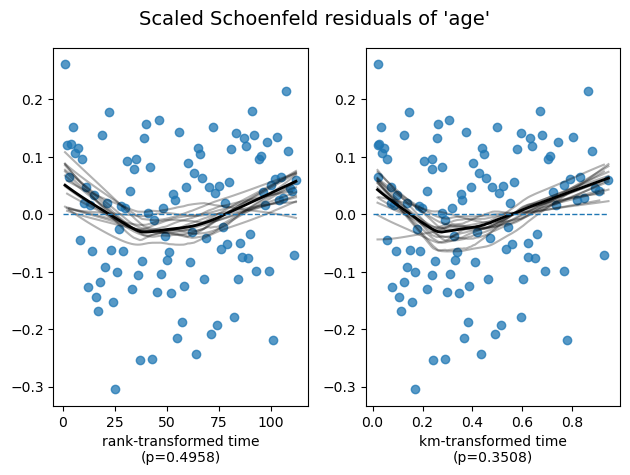

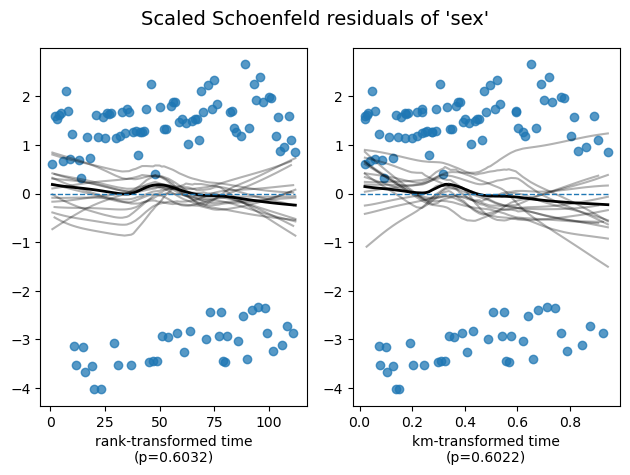

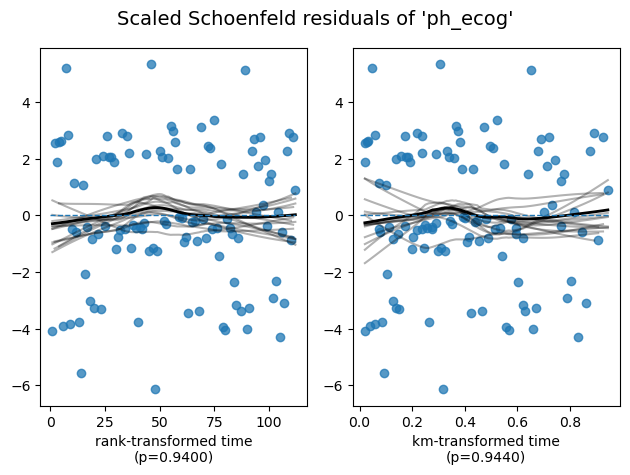

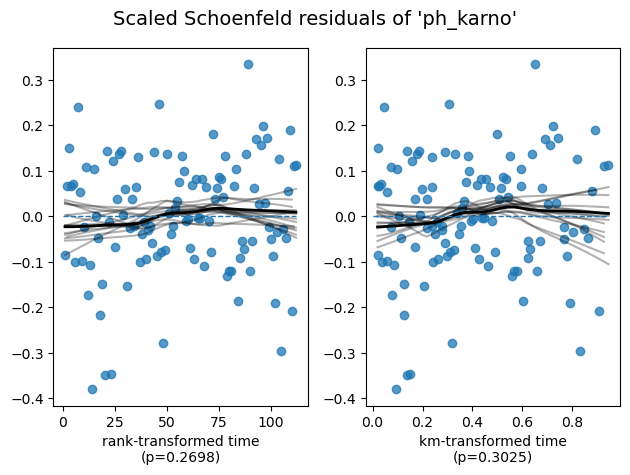

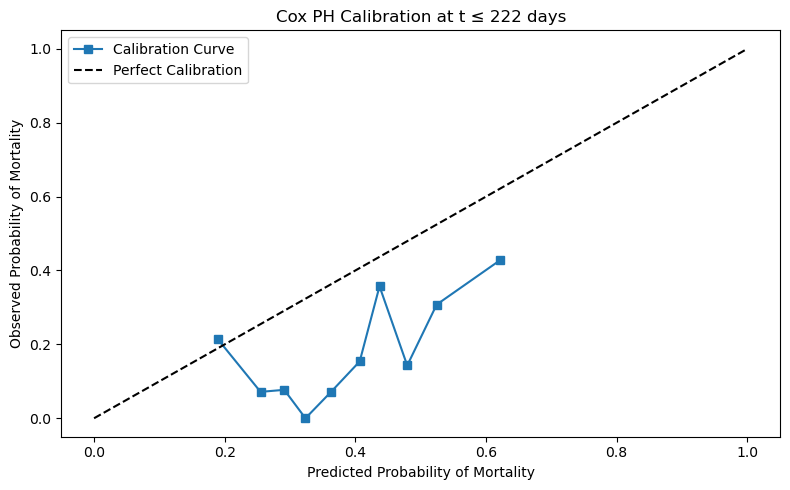

In [312]:
df_no_patkarno  = df_cph.copy().drop(columns=['pat_karno'])  
# 1. Cox PH Analysis
cph_model = run_cox_analysis(df_no_patkarno)


### Cox PH with all features


Cox Proportional Hazards Model


<lifelines.CoxPHFitter: fitted with 319 total observations, 207 right-censored observations>
             duration col = 'time'
                event col = 'dead'
      baseline estimation = breslow
   number of observations = 319
number of events observed = 112
   partial log-likelihood = -458.18
         time fit was run = 2025-08-15 17:32:55 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
age        0.01      1.01      0.01           -0.01            0.03                0.99                1.03
sex        0.62      1.86      0.21            0.21            1.03                1.24                2.79
ph_ecog    0.51      1.66      0.23            0.05            0.96                1.05                2.62
ph_karno   0.01      1.01      0.01           -0.01            0.04                0.99                1.04
pat_karno -0.01      0.99      0.01           -0.02            0.01                0.98                1.01

           cmp to     z      p  -log2(p)
covariate                               
age          0.00  0.96   0.34      1.56
sex          0.00  2.99 <0.005      8.47
ph_ecog      0.00  2.18   0.03      5.11
ph_karno     0.00  0.96   0.34      1.57
pat_karno    0.00 -0.71   0.48      1.06
---
Concordance = 0.62
Partial AIC = 926.35
log-likelihood ratio test = 19.46 on 5 df
-log2(p) of ll-ratio test = 9.31


Checking Proportional Hazards Assumptions:

   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.

Cox PH Concordance Index: 0.317

Brier Scores:
  Time 144.2 days: 0.1471
  Time 222.5 days: 0.2002
  Time 365.8 days: 0.2050


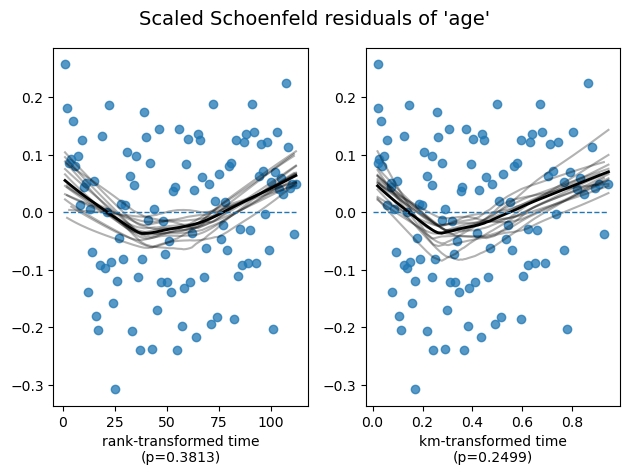

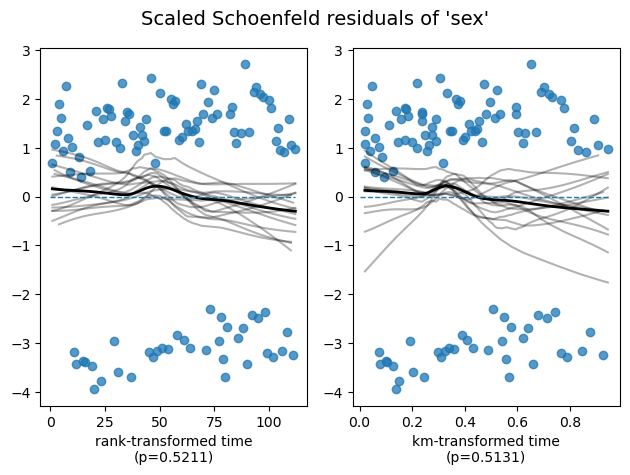

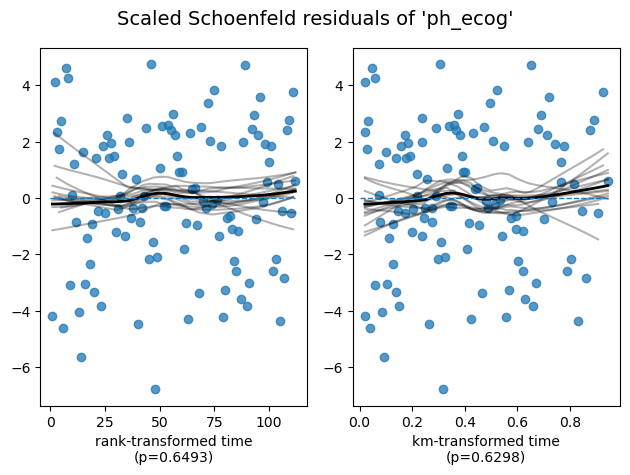

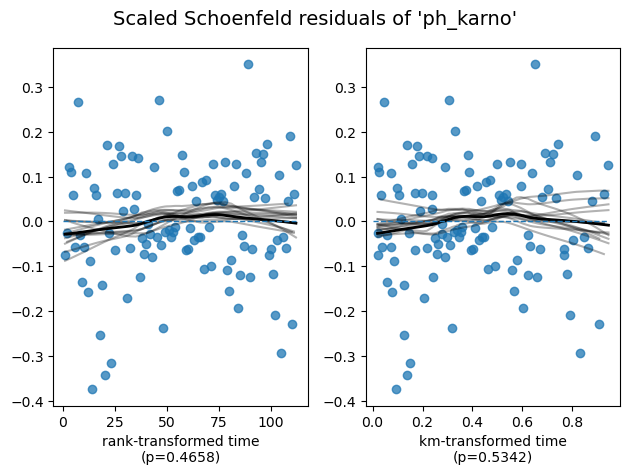

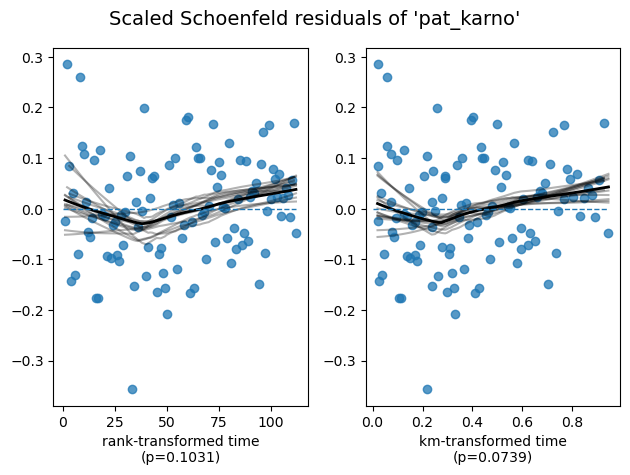

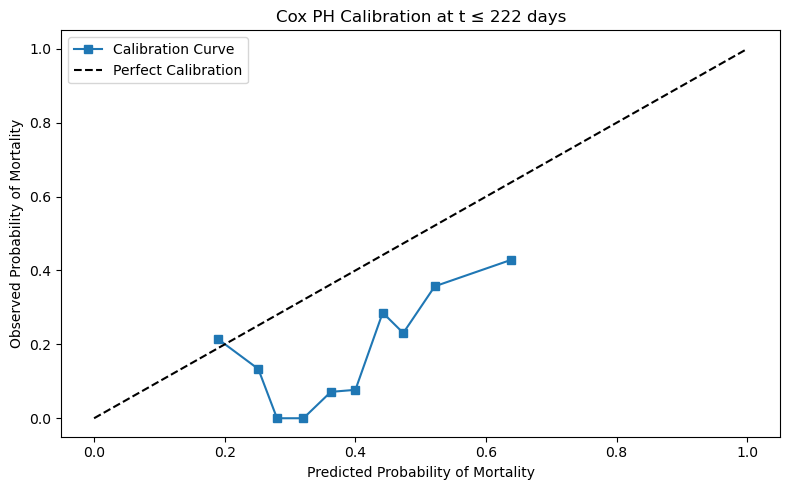

In [314]:
df = df_cph.copy()
    # 1. Cox PH Analysis
cph_model = run_cox_analysis(df)

# 2. Random Survival Forest

### Random Survival Forest without patkarno


Random Survival Forest Model

Statistical Significance Testing (Univariate Log-Rank):
sex: p-value = nan 
ph_ecog: p-value = 0.0189 *
Permutation Importance:
  sex: 0.1423
  age: 0.1417
  ph_karno: 0.0992
  ph_ecog: 0.0817

RSF Concordance Index: 0.591

Brier Scores:
  Time 144.2 days: 0.1841
  Time 222.5 days: 0.2606
  Time 365.8 days: 0.2969


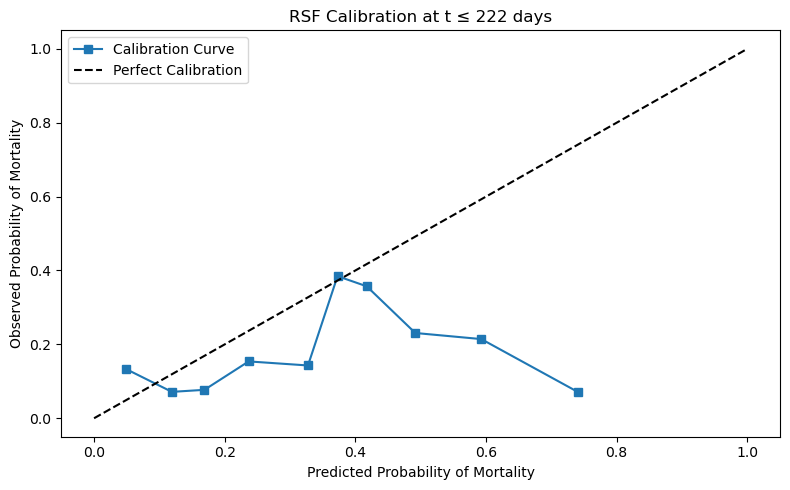

In [317]:
rsf_model = run_rsf_analysis(df_no_patkarno)

### Random Survival Forest with all features


Random Survival Forest Model

Statistical Significance Testing (Univariate Log-Rank):
sex: p-value = nan 
ph_ecog: p-value = 0.0189 *
Permutation Importance:
  sex: 0.1214
  age: 0.1062
  pat_karno: 0.1056
  ph_karno: 0.0784
  ph_ecog: 0.0595

RSF Concordance Index: 0.613

Brier Scores:
  Time 144.2 days: 0.1697
  Time 222.5 days: 0.2370
  Time 365.8 days: 0.2586


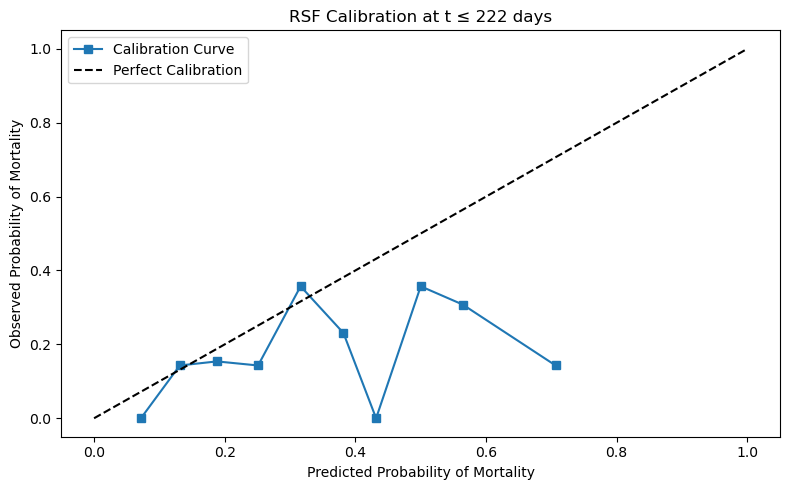

In [319]:
rsf_model = run_rsf_analysis(df)

# 3. Weibull Accelerated Failure Time Model

### Weibull AFT without patkarno


Weibull Accelerated Failure Time Model

Model Summary with Statistical Tests:


<lifelines.WeibullAFTFitter: fitted with 319 total observations, 207 right-censored observations>
             duration col = 'time'
                event col = 'dead'
   number of observations = 319
number of events observed = 112
           log-likelihood = -767.72
         time fit was run = 2025-08-15 17:33:14 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                  
lambda_ age       -0.01      0.99      0.01           -0.02            0.01                0.98                1.01
        ph_ecog   -0.36      0.69      0.16           -0.67           -0.06                0.51                0.95
        ph_karno  -0.01      0.99      0.01           -0.02            0.01                0.98                1.01
        sex       -0.43      0.65      0.14           -0.71           -0.15                0.49                0.86
        Intercept  7.61   2027.04      1.00            5.65            9.58              283.26            14505.95
rho_    Intercept  0.36      1.44      0.08            0.21            0.51                1.24                1.67

                   cmp to     z      p  -log2(p)
param   covariate                               
lambda_ age          0.00 -1.04   0.30      1.74
        ph_ecog      0.00 -2.31   0.02      5.60
        ph_karno     0.00 -0.76   0.45      1.15
        sex          0.00 -2.98 <0.005      8.45
        Intercept    0.00  7.58 <0.005     44.75
rho_    Intercept    0.00  4.75 <0.005     18.89
---
Concordance = 0.61
AIC = 1547.43
log-likelihood ratio test = 18.85 on 4 df
-log2(p) of ll-ratio test = 10.21

None

Detailed Statistical Significance:
--------------------------------
Null hypothesis: coefficient = 0 (no effect)
Alternative hypothesis: coefficient ≠ 0

Variable: ('lambda_', 'age')
  Coefficient: -0.0078
  exp(coef): 0.9922 (time ratio)
  p-value: 0.2985 
  95% CI: [-0.0225, 0.0069]
  Interpretation: A unit increase in ('lambda_', 'age') changes survival time by -0.8%
--------------------------------
Variable: ('lambda_', 'ph_ecog')
  Coefficient: -0.3645
  exp(coef): 0.6945 (time ratio)
  p-value: 0.0207 *
  95% CI: [-0.6733, -0.0558]
  Interpretation: A unit increase in ('lambda_', 'ph_ecog') changes survival time by -30.5%
--------------------------------
Variable: ('lambda_', 'ph_karno')
  Coefficient: -0.0065
  exp(coef): 0.9935 (time ratio)
  p-value: 0.4493 
  95% CI: [-0.0234, 0.0104]
  Interpretation: A unit increase in ('lambda_', 'ph_karno') changes survival time by -0.7%
--------------------------------
Variable: ('lambda_', 'sex')
  Coefficient: -0.4289
  exp(coef)

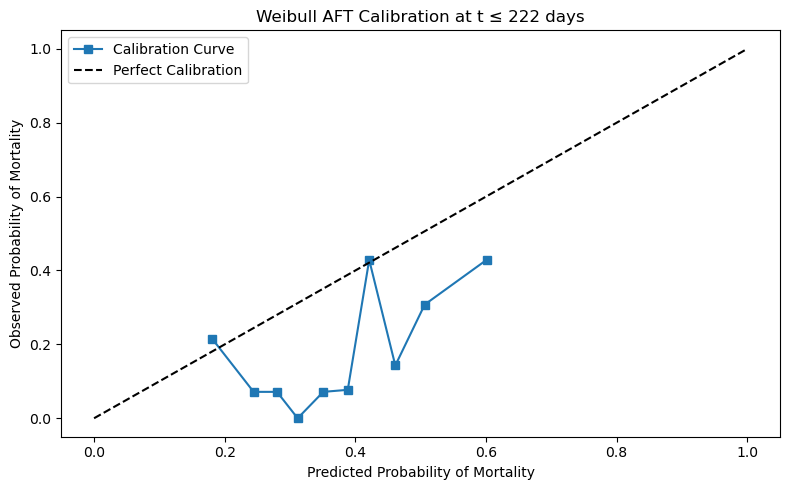

In [322]:
aft_model_no_patkarno = run_weibull_aft_analysis(df_no_patkarno)

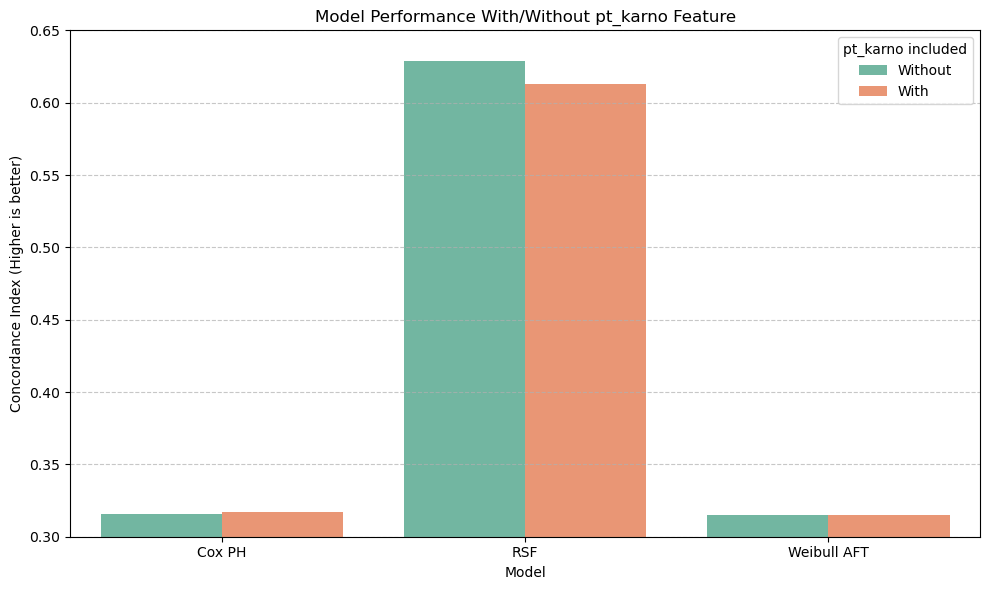


Performance Comparison:


,Model,pt_karno,Concordance_Index
0,Cox PH,Without,0.316
1,Cox PH,With,0.317
2,RSF,Without,0.629
3,RSF,With,0.613
4,Weibull AFT,Without,0.315
5,Weibull AFT,With,0.315



Key Observations:
1. Random Survival Forest (RSF) performs significantly better than parametric models (Cox PH and Weibull AFT)
2. Including pat_karno has minimal impact on Cox PH and Weibull AFT (difference < 0.002)
3. RSF performs slightly better WITHOUT pat_karno (0.629 vs 0.613)
4. All models show similar performance with/without pat_karno, suggesting it's not a strong predictor
5. The large gap between RSF and other models suggests non-linear relationships that RSF captures better


In [323]:
# Create comparison DataFrame
results = pd.DataFrame({
    'Model': ['Cox PH', 'Cox PH', 'RSF', 'RSF', 'Weibull AFT', 'Weibull AFT'],
    'pt_karno': ['Without', 'With', 'Without', 'With', 'Without', 'With'],
    'Concordance_Index': [0.316, 0.317, 0.629, 0.613, 0.315, 0.315]
})

# Plot comparison
plt.figure(figsize=(10, 6))
sns.barplot(data=results, x='Model', y='Concordance_Index', hue='pt_karno', palette='Set2')
plt.title('Model Performance With/Without pt_karno Feature')
plt.ylabel('Concordance Index (Higher is better)')
plt.ylim(0.3, 0.65)
plt.legend(title='pt_karno included')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Display the results table
print("\nPerformance Comparison:")
display(results)

# Analysis comments
print("\nKey Observations:")
print("1. Random Survival Forest (RSF) performs significantly better than parametric models (Cox PH and Weibull AFT)")
print("2. Including pat_karno has minimal impact on Cox PH and Weibull AFT (difference < 0.002)")
print("3. RSF performs slightly better WITHOUT pat_karno (0.629 vs 0.613)")
print("4. All models show similar performance with/without pat_karno, suggesting it's not a strong predictor")
print("5. The large gap between RSF and other models suggests non-linear relationships that RSF captures better")

## Key Observations:
1. Random Survival Forest (RSF) performs significantly better than parametric models (Cox PH and Weibull AFT)
2. Includinga pt_karno has minimal impact on Cox PH and Weibull AFT (difference < 0.002)
3. RSF performs slightly better WITHOUaT pt_karno (0.629 vs 0.613)
4. All models show similar performance with/withoaut pt_karno, suggesting it's not a strong predictor
5. The large gap between RSF and other models suggests non-linear relationships that RSF captures better